### Exploring the SEIRSPLUS library
Library source: https://github.com/ryansmcgee/seirsplus

Notebook source: https://github.com/ryansmcgee/seirsplus/blob/master/examples/network_model_demo.ipynb

In [18]:
from seirsplus.models import *
import networkx as nx
import pandas as pd
import numpy as np

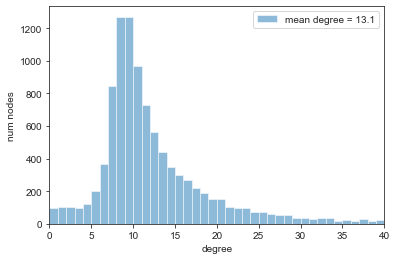

In [3]:
num_nodes = 10000
base_graph = networkx.barabasi_albert_graph(n=num_nodes, m=9)

# Baseline normal interactions:
G_normal = custom_exponential_graph(base_graph, scale=100)
plot_degree_distn(G_normal, max_degree=40)

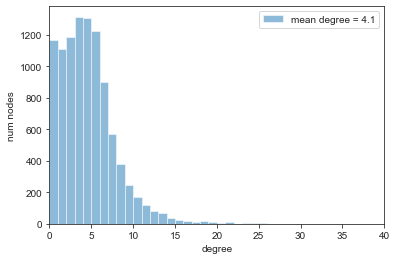

In [9]:
# Social distancing interactions:
G_distancing = custom_exponential_graph(base_graph, scale=10)
plot_degree_distn(G_distancing, max_degree=40)

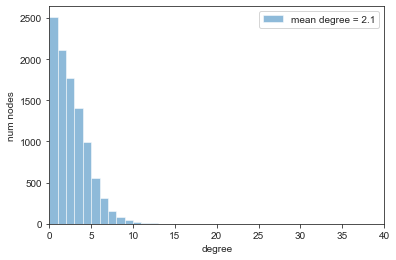

In [10]:
# Quarantine interactions:
G_quarantine = custom_exponential_graph(base_graph, scale=5)
plot_degree_distn(G_quarantine, max_degree=40)

In [11]:
# The parameter values shown correspond to rough estimates of parameter values for the COVID-19 epidemic.
model = SEIRSNetworkModel(G       =G_normal, 
                          beta    =0.155, 
                          sigma   =1/5.2, 
                          gamma   =1/12.39, 
                          mu_I    =0.0004,
                          mu_0    =0, 
                          nu      =0, 
                          xi      =0,
                          p       =0.5,
                          Q       =G_quarantine, 
                          beta_D  =0.155, 
                          sigma_D =1/5.2, 
                          gamma_D =1/12.39, 
                          mu_D    =0.0004,
                          theta_E =0, 
                          theta_I =0, 
                          phi_E   =0, 
                          phi_I   =0, 
                          psi_E   =1.0, 
                          psi_I   =1.0,
                          q       =0.5,
                          initI   =num_nodes/100, 
                          initE   =0, 
                          initD_E =0, 
                          initD_I =0, 
                          initR   =0, 
                          initF   =0)

### Checkpoints
Model parameters can be easily changed during a simulation run using checkpoints. A dictionary holds a list of checkpoint times (checkpoints['t']) and lists of new values to assign to various model parameters at each checkpoint time. Any model parameter listed in the model constrcutor can be updated in this way. Only model parameters that are included in the checkpoints dictionary have their values updated at the checkpoint times, all other parameters keep their pre-existing values.

_The checkpoints shown here correspond to starting social distancing and testing at time t=20 (the graph G is updated to G_distancing and locality parameter p is decreased to 0.1; testing params theta_E, theta_I, phi, and phi_I are set to non-zero values) and then stopping social distancing at time t=100 (G and p changed back to their "normal" values; testing params remain non-zero)._

In [12]:
checkpoints = {'t':       [20, 100], 
               'G':       [G_distancing, G_normal], 
               'p':       [0.1, 0.5], 
               'theta_E': [0.02, 0.02], 
               'theta_I': [0.02, 0.02], 
               'phi_E':   [0.2, 0.2], 
               'phi_I':   [0.2, 0.2]}

In [13]:
model.run(T=300, checkpoints=checkpoints)

t = 0.14
t = 10.03
[Checkpoint: Updating parameters]
t = 20.02
t = 30.02
t = 40.01
t = 50.02
t = 60.00
t = 70.00
t = 80.01
t = 90.03
[Checkpoint: Updating parameters]
t = 100.01
t = 110.01
t = 120.01
t = 130.03
t = 140.00
t = 150.01
t = 160.01
t = 170.01
t = 180.01
t = 190.02
t = 200.03
t = 210.00
t = 220.05
t = 230.02
t = 240.04
t = 250.00
t = 260.01
t = 270.00
t = 280.01
t = 290.15
t = 300.04


True

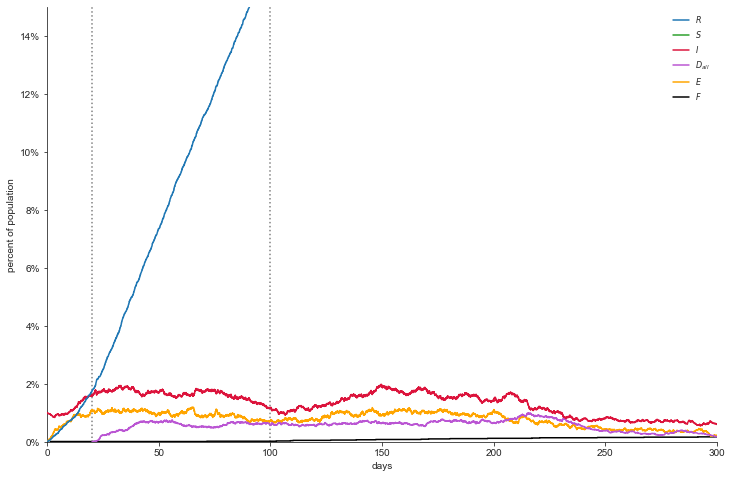

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a299c3d90>)

In [15]:
# Dotted lines: checkpoints, F = deceased, R = recovered
model.figure_basic(vlines=checkpoints['t'], ylim=0.15)

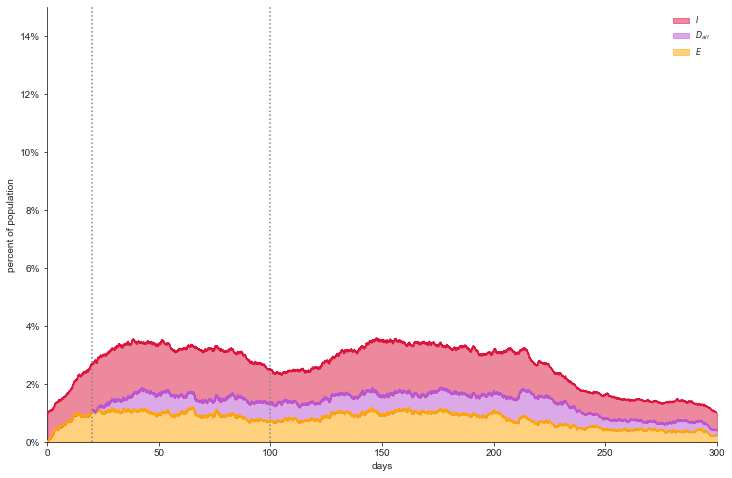

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a285e3cd0>)

In [16]:
# I = infected, D = detected, E = exposed
model.figure_infections(vlines=checkpoints['t'], ylim=0.15)

### Adding a heterogeneous population based on age 

In [38]:
# Death rate per age calculation - parameters found by fitting a sigmoid curve
A_MALES = -9.58814632
B_MALES = 0.61453804
A_FEMALES = -9.91023535
B_FEMALES = 0.47451181

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def deathrate_male(x):
    return sigmoid(np.sqrt(x) + A_MALES) * B_MALES


def deathrate_female(x):
    return sigmoid(np.sqrt(x) + A_FEMALES) * B_FEMALES

def get_deathrate(row):
    if row["sex"] == 0:
        return deathrate_male(row["age"])
    
    else:
        return deathrate_female(row["age"])

In [39]:
# Dataframe including age (V1) and sex (V2)
pop_df = pd.read_csv('data/age_and_sex.csv')
pop_df = pop_df[["V1", "V2"]].rename(columns={"V1": "age", "V2": "sex"})
pop_df.head()

,age,sex
0,2.1,1
1,25.6,0
2,23.6,0
3,49.6,1
4,28.6,0


In [42]:
# Get the deathrate of each person per age/sex
pop_df['death_rate'] = pop_df.apply(lambda row: get_deathrate(row), axis=1)

In [43]:
pop_df.head()

,age,sex,death_rate
0,2.1,1,0.000100
1,25.6,0,0.006564
2,23.6,0,0.005376
3,49.6,1,0.025521
4,28.6,0,0.008726


In [45]:
# Convert to list to give it as a network parameter
deathrates = list(pop_df["death_rate"])
len(deathrates)

12883

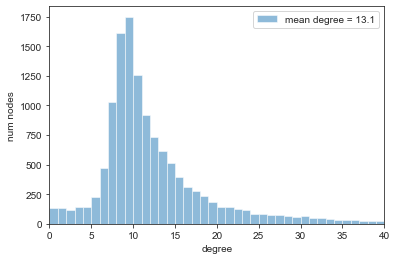

In [26]:
# README says that ~10,000 is a good number for population estimate - thankfully, our true number is close to 10,000!
camp_pop = 12883
camp_G = networkx.barabasi_albert_graph(n=camp_pop, m=9)

# Baseline normal interactions:
G_normal = custom_exponential_graph(camp_G, scale=100)
plot_degree_distn(G_normal, max_degree=40)

In [27]:
G_distancing = custom_exponential_graph(camp_G, scale=10)
G_quarantine = custom_exponential_graph(camp_G, scale=5)

In [29]:
model_w_age = SEIRSNetworkModel(G       =G_normal, 
                          beta    =0.155, 
                          sigma   =1/5.2, 
                          gamma   =1/12.39, 
                          mu_I    =deathrates,
                          mu_0    =0, 
                          nu      =0, 
                          xi      =0,
                          p       =0.5,
                          Q       =G_quarantine, 
                          beta_D  =0.155, 
                          sigma_D =1/5.2, 
                          gamma_D =1/12.39, 
                          mu_D    =0.0004,
                          theta_E =0, 
                          theta_I =0, 
                          phi_E   =0, 
                          phi_I   =0, 
                          psi_E   =1.0, 
                          psi_I   =1.0,
                          q       =0.5,
                          initI   =camp_pop/100, 
                          initE   =0, 
                          initD_E =0, 
                          initD_I =0, 
                          initR   =0, 
                          initF   =0)

In [47]:
# These represent WHEN the measures are taken (time step t) and HOW the parameters change
checkpoints = {'t':       [20, 100], 
               'G':       [G_distancing, G_normal], 
               'p':       [0.1, 0.5], 
               'theta_E': [0.02, 0.02], 
               'theta_I': [0.02, 0.02], 
               'phi_E':   [0.2, 0.2], 
               'phi_I':   [0.2, 0.2]}

In [32]:
model_w_age.run(T=300, checkpoints=checkpoints)

t = 0.02
t = 10.01
[Checkpoint: Updating parameters]
t = 20.00
t = 30.00
t = 40.06
t = 50.00
t = 60.01
t = 70.05
t = 80.01
t = 90.02
[Checkpoint: Updating parameters]
t = 100.03
t = 110.01
t = 120.01
t = 130.03
t = 140.00
t = 150.01
t = 160.00
t = 170.01
t = 180.01
t = 190.02
t = 200.02
t = 210.01
t = 220.03
t = 230.04
t = 240.00
t = 250.00
t = 260.05
t = 270.01
t = 280.09
t = 290.01
t = 300.03


True

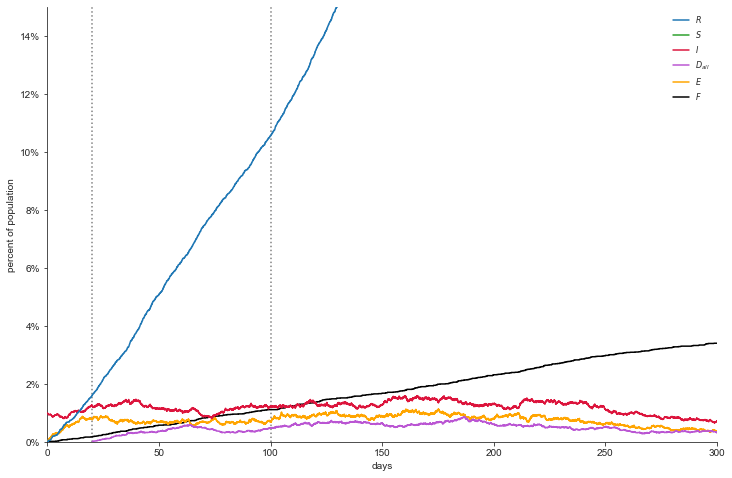

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a2f3ab610>)

In [34]:
model_w_age.figure_basic(vlines=checkpoints['t'], ylim=0.15)

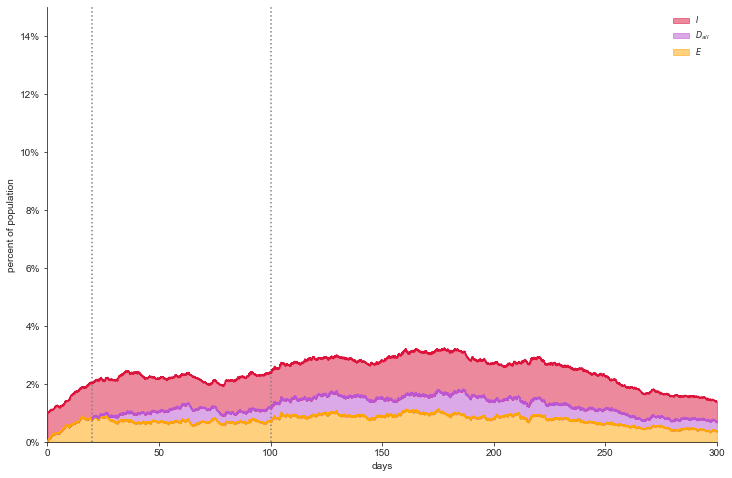

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a2ff96810>)

In [36]:
model_w_age.figure_infections(vlines=checkpoints['t'], ylim=0.15)

In [46]:
## Alternative scenario - no measures taken
ref_model = SEIRSNetworkModel(G=G_normal, beta=0.155, sigma=1/5.2, gamma=1/12.39, mu_I=deathrates, p=0.5,
                          Q=G_quarantine, beta_D=0.155, sigma_D=1/5.2, gamma_D=1/12.39, mu_D=0.0004,
                          theta_E=0, theta_I=0, phi_E=0, phi_I=0, psi_E=1.0, psi_I=1.0, q=0.5,
                          initI=camp_pop/100)
ref_model.run(T=300)

t = 0.05
t = 10.03
t = 20.03
t = 30.01
t = 40.00
t = 50.00
t = 60.01
t = 70.00
t = 80.00
t = 90.01
t = 100.01
t = 110.00
t = 120.01
t = 130.00
t = 140.00
t = 150.00
t = 160.01
t = 170.01
t = 180.01
t = 190.00
t = 200.01
t = 210.00
t = 220.06
t = 230.00
t = 240.05
t = 250.26
t = 260.97
t = 270.01
t = 280.32
t = 300.85


True

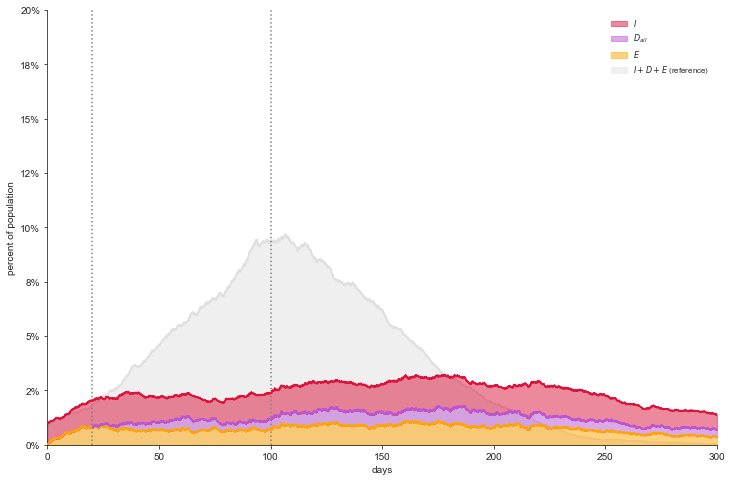

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a35096ad0>)

In [48]:
model_w_age.figure_infections(vlines=checkpoints['t'], ylim=0.2, shaded_reference_results=ref_model)